In [63]:
import numpy as np
import caer 
import os
import canaro
import cv2
import gc

In [64]:
IMG_SIZE = (80, 80)
channels = 1
char_path = r'D:\opencv-python\SimpsonsDeepVisionModel\simpsons_dataset'
print(os.getcwd()) 
os.chdir("d:\\")  
print(os.getcwd()) 

d:\
d:\


In [65]:
char_dict = {}
for char in os.listdir('D:\opencv-python\SimpsonsDeepVisionModel\simpsons_dataset'):
    char_dict[char] = len(os.listdir(os.path.join(char_path, char)))

# Sorting In Decending Order
char_dict = caer.sort_dict(char_dict, descending=True)
char_dict

[('homer_simpson', 2246),
 ('ned_flanders', 1454),
 ('moe_szyslak', 1452),
 ('lisa_simpson', 1354),
 ('bart_simpson', 1342),
 ('marge_simpson', 1291),
 ('krusty_the_clown', 1206),
 ('principal_skinner', 1194),
 ('charles_montgomery_burns', 1193),
 ('milhouse_van_houten', 1079),
 ('chief_wiggum', 986),
 ('abraham_grampa_simpson', 913),
 ('sideshow_bob', 877),
 ('apu_nahasapeemapetilon', 623),
 ('kent_brockman', 498),
 ('comic_book_guy', 469),
 ('edna_krabappel', 457),
 ('nelson_muntz', 358),
 ('lenny_leonard', 310),
 ('mayor_quimby', 246),
 ('waylon_smithers', 181),
 ('maggie_simpson', 128),
 ('groundskeeper_willie', 121),
 ('barney_gumble', 106),
 ('selma_bouvier', 103),
 ('carl_carlson', 98),
 ('ralph_wiggum', 89),
 ('patty_bouvier', 72),
 ('martin_prince', 71),
 ('professor_john_frink', 65),
 ('snake_jailbird', 55),
 ('cletus_spuckler', 47),
 ('rainier_wolfcastle', 45),
 ('agnes_skinner', 42),
 ('simpsons_dataset', 42),
 ('sideshow_mel', 40),
 ('otto_mann', 32),
 ('fat_tony', 27),
 (

In [66]:
characters = []
count = 0
for i in char_dict:
    count+=1
    characters.append(i[0])
    if count>=10:
        break
characters

['homer_simpson',
 'ned_flanders',
 'moe_szyslak',
 'lisa_simpson',
 'bart_simpson',
 'marge_simpson',
 'krusty_the_clown',
 'principal_skinner',
 'charles_montgomery_burns',
 'milhouse_van_houten']

In [67]:
#Create A Training Data
train = caer.preprocess_from_dir(char_path, characters, channels=channels, IMG_SIZE=IMG_SIZE, isShuffle=True)

[INFO] Could not find a file to load from. Generating the training data
----------------------------------------------
[INFO] At 1000 files
[INFO] At 2000 files
[INFO] 2246 files found in 0.014981985092163086s
[INFO] At 1000 files
[INFO] 1454 files found in 0.01248621940612793s
[INFO] At 1000 files
[INFO] 1452 files found in 0.003988981246948242s
[INFO] At 1000 files
[INFO] 1354 files found in 0.007039785385131836s
[INFO] At 1000 files
[INFO] 1342 files found in 0.0049893856048583984s
[INFO] At 1000 files
[INFO] 1291 files found in 0.005490541458129883s
[INFO] At 1000 files
[INFO] 1206 files found in 0.009591341018676758s
[INFO] At 1000 files
[INFO] 1194 files found in 0.002991199493408203s
[INFO] At 1000 files
[INFO] 1193 files found in 0.004988670349121094s
[INFO] At 1000 files
[INFO] 1079 files found in 0.009007453918457031s
----------------------------------------------
[INFO] 13811 files preprocessed! Took 1m 3s


In [68]:
len(train)

13811

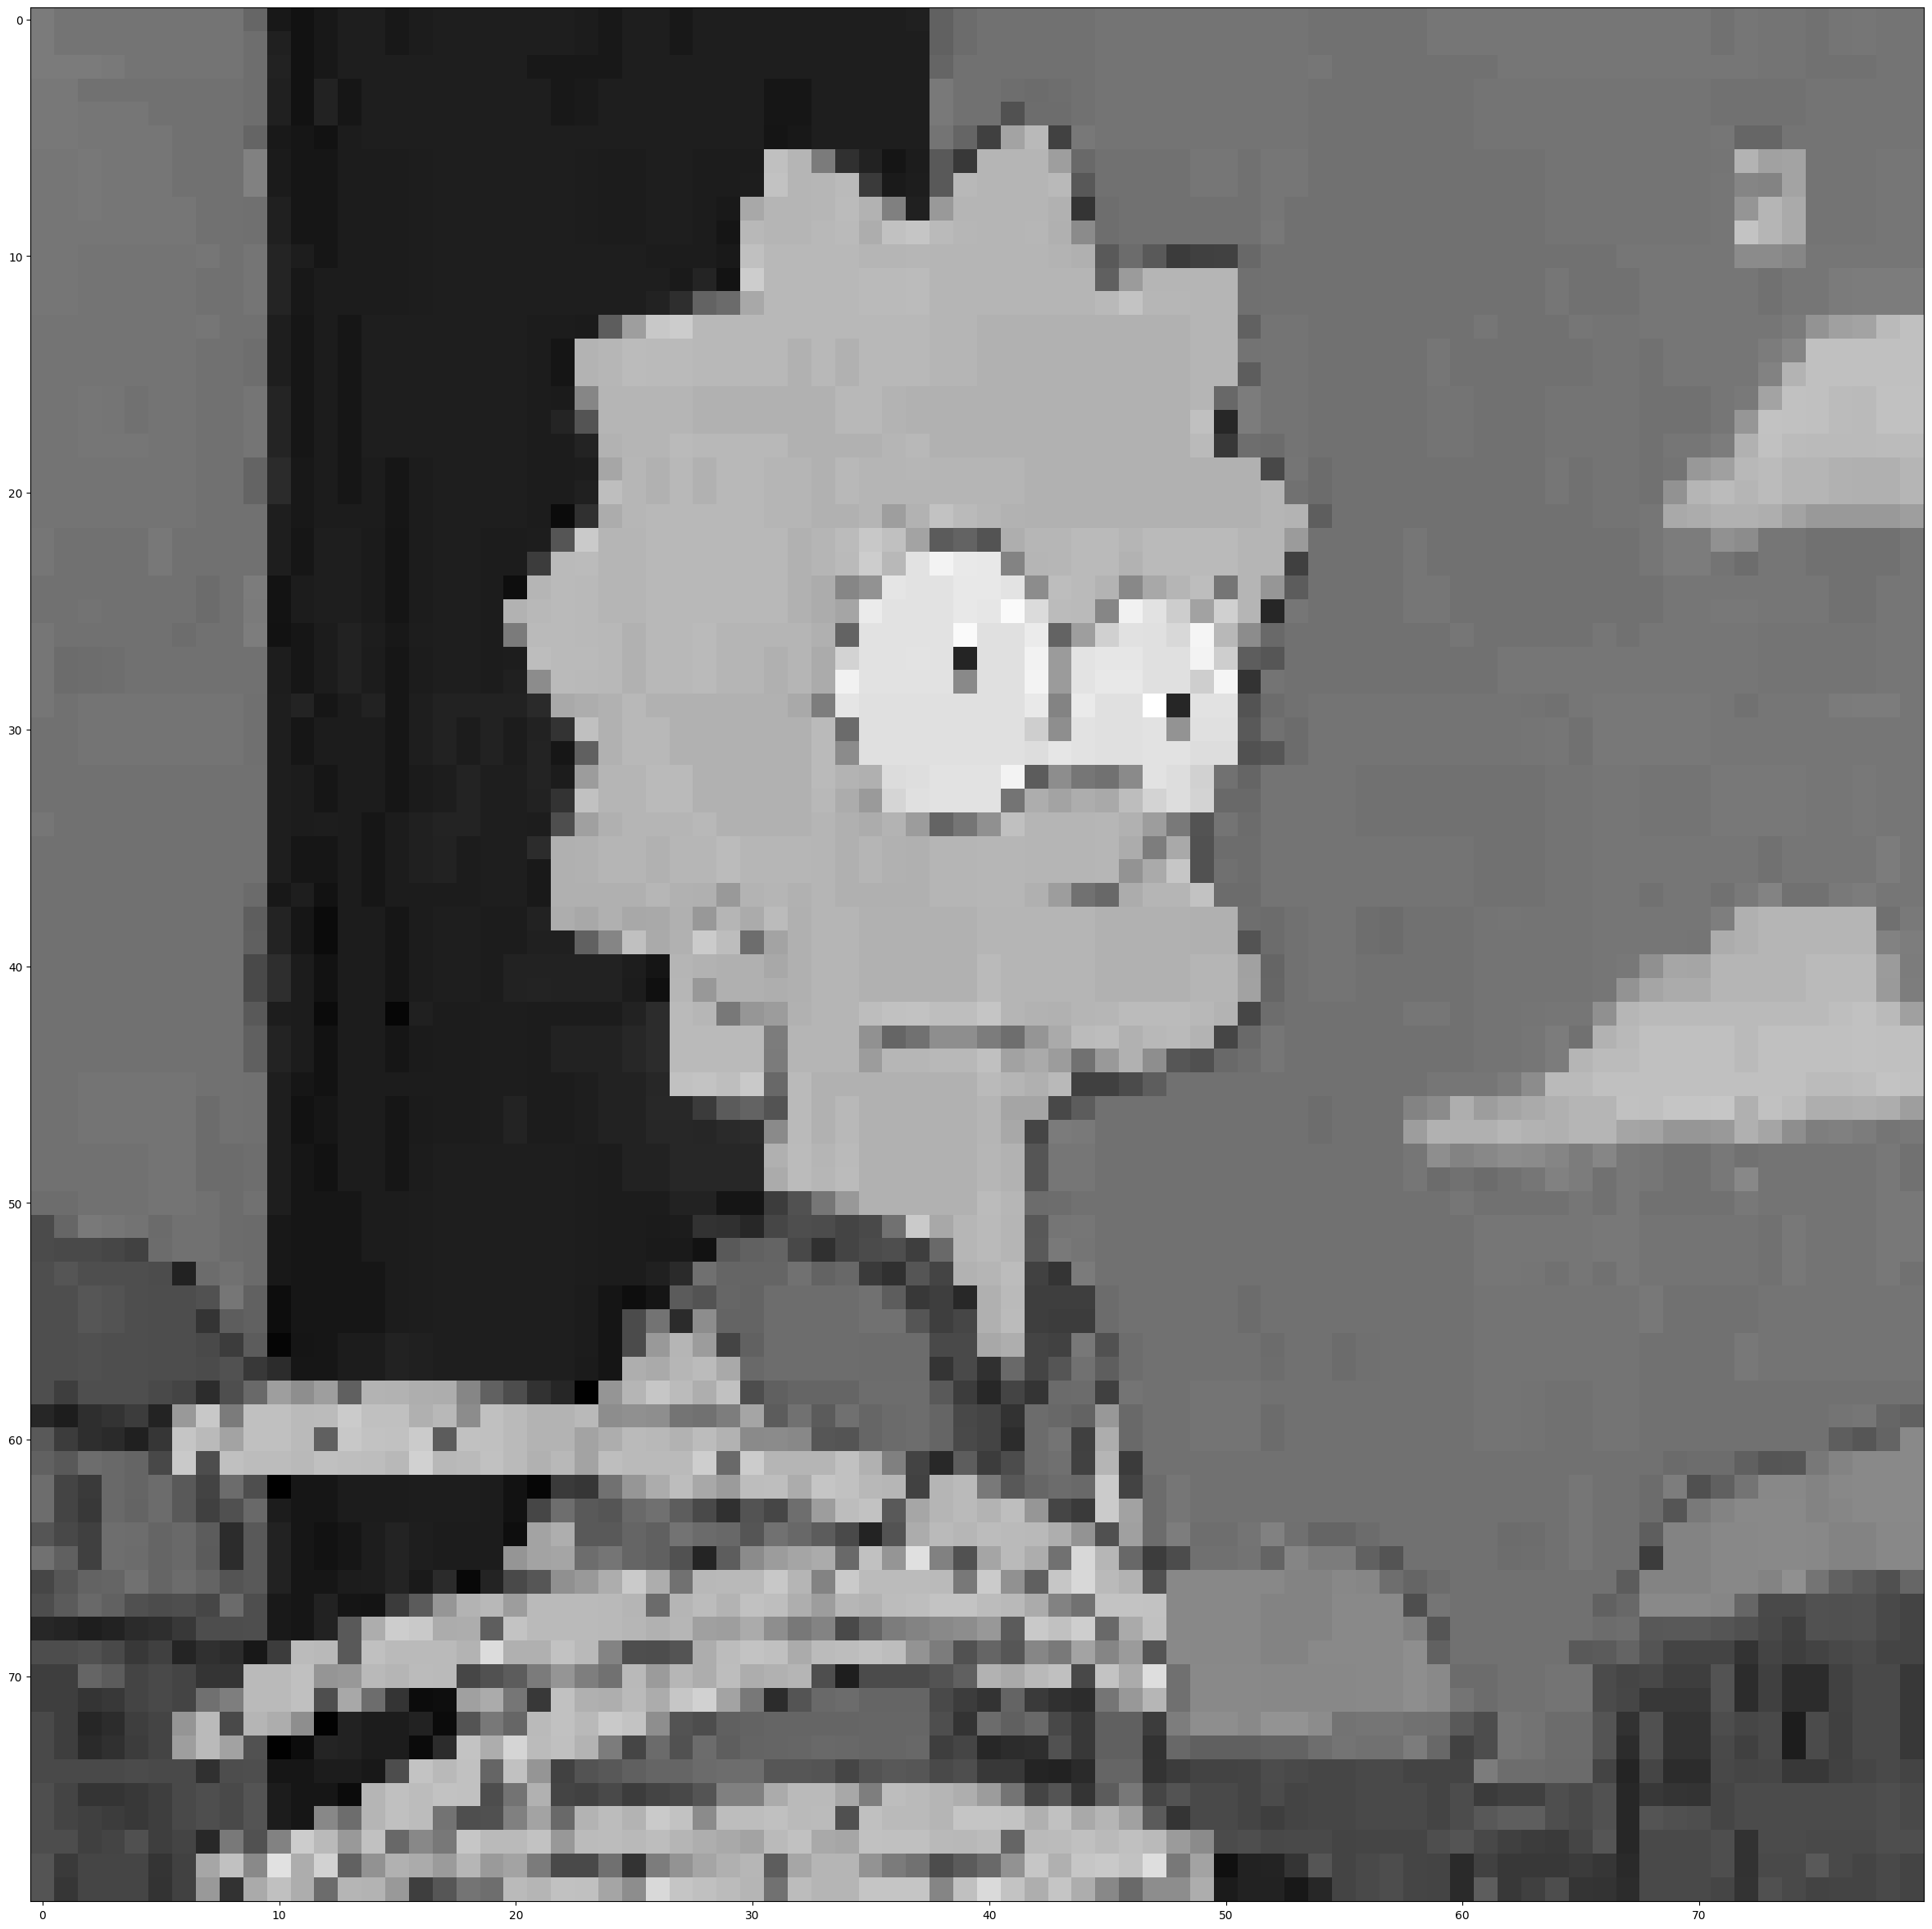

In [69]:
import matplotlib.pyplot as plt
plt.figure(figsize = (30,30))
plt.imshow(train[0][0], cmap='gray')
plt.show()

In [70]:
featureSet, labels = caer.sep_train(train, IMG_SIZE=IMG_SIZE)

In [71]:
from tensorflow.keras.utils import to_categorical
# Normalize the feature ==> (0,1)
featureSet = caer.normalize(featureSet)
labels = to_categorical(labels, len(characters))

In [72]:
x_train, x_val, y_train, y_val = caer.train_val_split(featureSet, labels, val_ratio=0.2)

In [73]:
del train
del featureSet
del labels
gc.collect()

0

In [74]:
BATCH_SIZE = 32
EPOCHS = 10

In [75]:
# Image data generator
datagen = canaro.generators.imageDataGenerator()
train_gen = datagen.flow(x_train, y_train, batch_size = BATCH_SIZE)

In [76]:
#Creating The Model
model = canaro.models.createSimpsonsModel(IMG_SIZE=IMG_SIZE, channels=channels, output_dim=len(characters), loss='binary_crossentropy', decay= 1e-6, learning_rate = 0.001, momentum=0.9, nesterov=True)

C:\Users\Acer\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [77]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 80, 80, 32)        320       
                                                                 
 conv2d_7 (Conv2D)           (None, 78, 78, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 39, 39, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 39, 39, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 39, 39, 64)        18496     
                                                                 
 conv2d_9 (Conv2D)           (None, 37, 37, 64)        36928     
                                                      

In [78]:
from tensorflow.keras.callbacks import LearningRateScheduler
callbacks_list = [LearningRateScheduler(canaro.lr_schedule)]

In [79]:
from gc import callbacks


training =  model.fit(train_gen, 
                        steps_per_epoch=len(x_train)//BATCH_SIZE, 
                        epochs=EPOCHS, validation_data=(x_val, y_val), 
                        validation_steps=len(y_val)//BATCH_SIZE,
                        callbacks=callbacks_list)

Epoch 1/10
345/345 [==============================] - 371s 1s/step - loss: 0.3408 - accuracy: 0.1567 - val_loss: 0.3327 - val_accuracy: 0.1498 - lr: 0.0100
Epoch 2/10
345/345 [==============================] - 363s 1s/step - loss: 0.3235 - accuracy: 0.1641 - lr: 0.0100
Epoch 3/10
345/345 [==============================] - 338s 978ms/step - loss: 0.3230 - accuracy: 0.1656 - lr: 0.0100
Epoch 4/10
345/345 [==============================] - 319s 924ms/step - loss: 0.3220 - accuracy: 0.1653 - lr: 0.0100
Epoch 5/10
345/345 [==============================] - 330s 957ms/step - loss: 0.3134 - accuracy: 0.2015 - lr: 0.0100
Epoch 6/10
345/345 [==============================] - 339s 981ms/step - loss: 0.3061 - accuracy: 0.2416 - lr: 0.0100
Epoch 7/10
345/345 [==============================] - 328s 950ms/step - loss: 0.3027 - accuracy: 0.2555 - lr: 0.0100
Epoch 8/10
345/345 [==============================] - 339s 983ms/step - loss: 0.2992 - accuracy: 0.2660 - lr: 0.0100
Epoch 9/10
345/345 [========

In [80]:
characters

['homer_simpson',
 'ned_flanders',
 'moe_szyslak',
 'lisa_simpson',
 'bart_simpson',
 'marge_simpson',
 'krusty_the_clown',
 'principal_skinner',
 'charles_montgomery_burns',
 'milhouse_van_houten']

In [84]:
test_path = r'D:\opencv-python\SimpsonsDeepVisionModel\kaggle_simpson_testset\kaggle_simpson_testset\bart_simpson_38.jpg'

img = cv2.imread(test_path)


def prepare(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, IMG_SIZE)
    img = caer.reshape(img, IMG_SIZE, 1)
    return img


In [85]:
prediction = model.predict(prepare(img))
prediction

1/1 [==============================] - 0s 295ms/step


array([[1.000000e+00, 0.000000e+00, 0.000000e+00, 3.944622e-14,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00]], dtype=float32)

In [86]:
print(characters[np.argmax(prediction[0])])

homer_simpson
